In [129]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL

In [130]:
device = torch.device("cuda")

In [3]:
import torch
import numpy as np
import random
from scipy.linalg import sqrtm
from sklearn import datasets

class Sampler:
    def __init__(
        self, device='cuda',
    ):
        self.device = device

    def sample(self, size=5):
        pass

class LoaderSampler(Sampler):
    def __init__(self, loader, device='cuda'):
        super(LoaderSampler, self).__init__(device)
        self.loader = loader
        self.it = iter(self.loader)

    def sample(self, size=5):
        assert size <= self.loader.batch_size
        try:
            batch, _ = next(self.it)
        except StopIteration:
            self.it = iter(self.loader)
            return self.sample(size)
        if len(batch) < size:
            return self.sample(size)

        return batch[:size].to(self.device)



In [4]:
def get_random_colored_images(images, seed = 0x000000):
    np.random.seed(seed)

    images = 0.5*(images + 1)
    size = images.shape[0]
    colored_images = []
    hues = 360*np.random.rand(size)

    for V, H in zip(images, hues):
        V_min = 0

        a = (V - V_min)*(H%60)/60
        V_inc = a
        V_dec = V - a

        colored_image = torch.zeros((3, V.shape[1], V.shape[2]))
        H_i = round(H/60) % 6

        if H_i == 0:
            colored_image[0] = V
            colored_image[1] = V_inc
            colored_image[2] = V_min
        elif H_i == 1:
            colored_image[0] = V_dec
            colored_image[1] = V
            colored_image[2] = V_min
        elif H_i == 2:
            colored_image[0] = V_min
            colored_image[1] = V
            colored_image[2] = V_inc
        elif H_i == 3:
            colored_image[0] = V_min
            colored_image[1] = V_dec
            colored_image[2] = V
        elif H_i == 4:
            colored_image[0] = V_inc
            colored_image[1] = V_min
            colored_image[2] = V
        elif H_i == 5:
            colored_image[0] = V
            colored_image[1] = V_min
            colored_image[2] = V_dec

        colored_images.append(colored_image)

    colored_images = torch.stack(colored_images, dim = 0)
    colored_images = 2*colored_images - 1

    return colored_images

In [5]:
import torchvision
from torch.utils.data import TensorDataset
from torch.utils.data import Subset, DataLoader, Dataset
def load_dataset(name, path, img_size=32, batch_size=64,
                 shuffle=True, device='cuda', return_dataset=False,
                 num_workers=0):
        # In case of using certain classe from the MNIST dataset you need to specify them by writing in the next format "MNIST_{digit}_{digit}_..._{digit}"
    transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1]
])

    dataset_name = name.split("_")[0]
    is_colored = True#dataset_name[-7:] == "colored"

    classes = [int(number) for number in name.split("_")[1:]]
    if not classes:
        classes = [i for i in range(10)]

    train_set = torchvision.datasets.MNIST(path, train=True, transform=transform, download=True)
    test_set = torchvision.datasets.MNIST(path, train=False, transform=transform, download=True)

    train_test = []

    for dataset in [train_set, test_set]:
        data = []
        labels = []
        for k in range(len(classes)):
            data.append(torch.stack(
                [dataset[i][0] for i in range(len(dataset.targets)) if dataset.targets[i] == classes[k]],
                dim=0
            ))
            labels += [k]*data[-1].shape[0]
        data = torch.cat(data, dim=0)
        data = data.reshape(-1, 1, 32, 32)
        labels = torch.tensor(labels)

        if is_colored:
            data = get_random_colored_images(data)

        train_test.append(TensorDataset(data, labels))

    train_set, test_set = train_test

    if return_dataset:
        return train_set, test_set

    train_sampler = DataLoader(train_set, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size, drop_last=True)
    test_sampler = DataLoader(test_set, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size, drop_last=True)
    return train_sampler, test_sampler


In [6]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [7]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [138]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 1000, schedule = 'linear'):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        self.betas = torch.from_numpy(get_named_beta_schedule(schedule, timesteps)).float() #torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



In [9]:
IMAGE_SHAPE = (32, 32)

In [139]:
diffusion_model = DiffusionModel()
dm_cosine = DiffusionModel(schedule='cosine')
dm_sigmoid = DiffusionModel(schedule='sigmoid')

<Axes: >

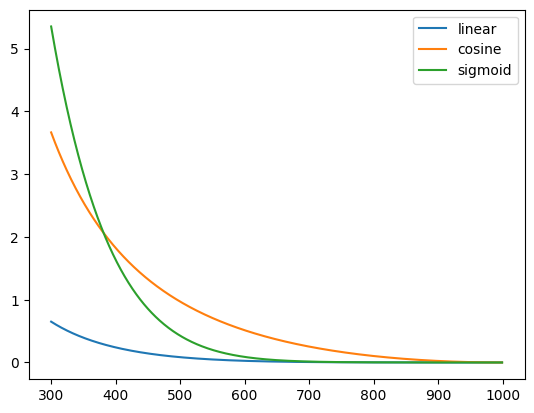

In [141]:
import seaborn as sns
sns.lineplot(y=(diffusion_model.alphas_cumprod / (1 - diffusion_model.alphas_cumprod))[300:], x=np.arange(300, 1000), label='linear')
sns.lineplot(y=(dm_cosine.alphas_cumprod / (1 - dm_cosine.alphas_cumprod))[300:], x=np.arange(300, 1000), label='cosine')
sns.lineplot(y=(dm_sigmoid.alphas_cumprod / (1 - dm_sigmoid.alphas_cumprod))[300:], x=np.arange(300, 1000), label='sigmoid')

In [11]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [13]:
f = 5
class Block(nn.Module):
    global f
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        global f, kk
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        kk = (o_time, o)
        f = o_time
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [12]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 256, labels = False, sequence_channels = (64, 128, 256, 512)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

In [34]:
BATCH_SIZE = 128
NO_EPOCHS = 500
PRINT_FREQUENCY = 5
LR = 0.001
VERBOSE = False

unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [75]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)

trainloader, testloader = load_dataset("mnist", './', batch_size=BATCH_SIZE)

100%|██████████| 9912422/9912422 [00:00<00:00, 104118100.95it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35902695.26it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33305681.21it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16667129.28it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [128]:
# some functions you will need

import math


# utility function. basically, returns arr[timesteps], where timesteps are indices. (look at class Diffusion)
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices into torch array to extract. (shape is [batch_size])
    :param broadcast_shape: a larger shape of K dimensions; output shape will be broadcasted to this
                            by adding new dimensions of size 1.
                            the first dimension of output tensor will be equal to length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where tensor shape has K dims.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

# out beta_t. we use linear scheduler
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "quad":
        betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps) ** 2
        return betas.numpy()
    elif schedule_name == "sigmoid":
        betas = torch.linspace(-6, 6, num_diffusion_timesteps)
        betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
        return betas.numpy()
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

In [17]:
cosine_sched = get_named_beta_schedule('cosine', 1000)

<Axes: >

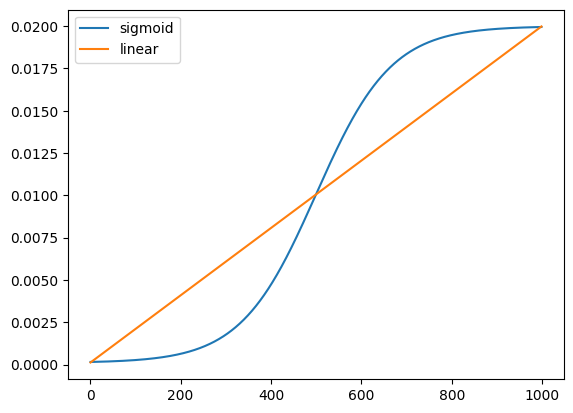

In [137]:
import seaborn as sns
# sns.lineplot(x = np.arange(1000)[1:-1], y=get_named_beta_schedule('cosine', 1000)[1:-1], label='cosine')
sns.lineplot(x = np.arange(1000)[1:-1], y=get_named_beta_schedule('sigmoid', 1000)[1:-1], label='sigmoid')
sns.lineplot(x = np.arange(1000)[1:-1], y=get_named_beta_schedule('linear', 1000)[1:-1], label='linear')

In [ ]:
epoch=0

In [ ]:
from tqdm import tqdm
for epoch in range(epoch, NO_EPOCHS):
    unet.train()
    print(f'Epoch {epoch}')
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in tqdm(trainloader):
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise, reduction='none').mean()
        mean_epoch_loss.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        optimizer.step()

    for batch, label in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

        torch.save(unet.state_dict(), f"epoch_sigmoid : {epoch}")

Epoch 0


100%|██████████| 468/468 [00:43<00:00, 10.64it/s]


---
Epoch: 0 | Train Loss 0.03499445866029232 | Val Loss 0.03048204917174119
Epoch 1


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 2


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


Epoch 3


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 4


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


Epoch 5


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


---
Epoch: 5 | Train Loss 0.021244476057796016 | Val Loss 0.02059433463578805
Epoch 6


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 7


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


Epoch 8


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


Epoch 9


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 10


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


---
Epoch: 10 | Train Loss 0.017992766775015708 | Val Loss 0.018155925405713227
Epoch 11


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


Epoch 12


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


Epoch 13


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 14


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 15


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


---
Epoch: 15 | Train Loss 0.01670776067986193 | Val Loss 0.01575760876473326
Epoch 16


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 17


100%|██████████| 468/468 [00:43<00:00, 10.65it/s]


Epoch 18


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 19


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 20


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


---
Epoch: 20 | Train Loss 0.015388547375193264 | Val Loss 0.014944406214337319
Epoch 21


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 22


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 23


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 24


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


Epoch 25


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


---
Epoch: 25 | Train Loss 0.014946925127480784 | Val Loss 0.01483912441210869
Epoch 26


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 27


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


Epoch 28


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


Epoch 29


100%|██████████| 468/468 [00:43<00:00, 10.65it/s]


Epoch 30


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


---
Epoch: 30 | Train Loss 0.014423363997290531 | Val Loss 0.014317969409510111
Epoch 31


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 32


100%|██████████| 468/468 [00:43<00:00, 10.65it/s]


Epoch 33


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 34


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


Epoch 35


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


---
Epoch: 35 | Train Loss 0.01391859711585646 | Val Loss 0.014113770762028603
Epoch 36


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 37


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 38


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 39


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 40


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


---
Epoch: 40 | Train Loss 0.013402307047866859 | Val Loss 0.013534057467507247
Epoch 41


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 42


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 43


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


Epoch 44


100%|██████████| 468/468 [00:43<00:00, 10.65it/s]


Epoch 45


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


---
Epoch: 45 | Train Loss 0.01332148677136144 | Val Loss 0.013189001546169702
Epoch 46


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


Epoch 47


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 48


100%|██████████| 468/468 [00:43<00:00, 10.64it/s]


Epoch 49


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 50


100%|██████████| 468/468 [00:43<00:00, 10.65it/s]


---
Epoch: 50 | Train Loss 0.013324080980343059 | Val Loss 0.013144890264345285
Epoch 51


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 52


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 53


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


Epoch 54


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


Epoch 55


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


---
Epoch: 55 | Train Loss 0.012911743136186503 | Val Loss 0.012681047527644878
Epoch 56


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 57


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 58


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 59


100%|██████████| 468/468 [00:43<00:00, 10.64it/s]


Epoch 60


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


---
Epoch: 60 | Train Loss 0.012528284017044382 | Val Loss 0.012677849401743749
Epoch 61


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


Epoch 62


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 63


100%|██████████| 468/468 [00:43<00:00, 10.71it/s]


Epoch 64


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 65


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


---
Epoch: 65 | Train Loss 0.012535321225738551 | Val Loss 0.01229421777698474
Epoch 66


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 67


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 68


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 69


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 70


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


---
Epoch: 70 | Train Loss 0.012312734491613686 | Val Loss 0.012252150485530878
Epoch 71


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 72


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 73


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 74


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 75


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


---
Epoch: 75 | Train Loss 0.012343792610952998 | Val Loss 0.012145304264357457
Epoch 76


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 77


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 78


100%|██████████| 468/468 [00:43<00:00, 10.66it/s]


Epoch 79


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 80


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


---
Epoch: 80 | Train Loss 0.012122090296963086 | Val Loss 0.012023959201402389
Epoch 81


100%|██████████| 468/468 [00:43<00:00, 10.65it/s]


Epoch 82


100%|██████████| 468/468 [00:43<00:00, 10.65it/s]


Epoch 83


100%|██████████| 468/468 [00:44<00:00, 10.63it/s]


Epoch 84


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 85


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


---
Epoch: 85 | Train Loss 0.011979678982040949 | Val Loss 0.012214219675232202
Epoch 86


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 87


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 88


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 89


100%|██████████| 468/468 [00:43<00:00, 10.67it/s]


Epoch 90


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


---
Epoch: 90 | Train Loss 0.01196628158641422 | Val Loss 0.011847214689717079
Epoch 91


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 92


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 93


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 94


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 95


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


---
Epoch: 95 | Train Loss 0.011802414706788765 | Val Loss 0.011787055119967613
Epoch 96


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 97


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 98


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 99


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 100


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


---
Epoch: 100 | Train Loss 0.011818216484772343 | Val Loss 0.011593775298350897
Epoch 101


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 102


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 103


100%|██████████| 468/468 [00:43<00:00, 10.70it/s]


Epoch 104


100%|██████████| 468/468 [00:43<00:00, 10.68it/s]


Epoch 105


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


---
Epoch: 105 | Train Loss 0.011822051332833676 | Val Loss 0.01179087347088334
Epoch 106


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 107


100%|██████████| 468/468 [00:43<00:00, 10.69it/s]


Epoch 108


 79%|███████▉  | 370/468 [00:34<00:09, 10.70it/s]

In [ ]:
mean_epoch_loss_val

[]

In [165]:
unet = UNet(labels=True).to(device)
unet.load_state_dict(torch.load(("epoch_200")))

<All keys matched successfully>

In [176]:
loss_arr = [0] * 1000
from tqdm import tqdm
with torch.no_grad():
  for t_i in tqdm(range(1000)):
        t = torch.randint(t_i, t_i + 1, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        loss_arr[t_i] += loss.detach().cpu().item()

100%|██████████| 1000/1000 [01:00<00:00, 16.45it/s]


In [177]:
unet = UNet(labels=True).to(device)
unet.load_state_dict(torch.load(("epoch_sigmoid_180")))

loss_arr_sigm = [0] * 1000

from tqdm import tqdm
with torch.no_grad():
  for t_i in tqdm(range(1000)):
        t = torch.randint(t_i, t_i + 1, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = dm_sigmoid.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        loss_arr_sigm[t_i] += loss.detach().cpu().item()

100%|██████████| 1000/1000 [01:00<00:00, 16.54it/s]


In [178]:
unet = UNet(labels=True).to(device)
unet.load_state_dict(torch.load(("epoch_cosine_120")))

loss_arr_cos = [0] * 1000

with torch.no_grad():
  for t_i in tqdm(range(1000)):
        t = torch.randint(t_i, t_i + 1, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = dm_sigmoid.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        loss_arr_cos[t_i] += loss.detach().cpu().item()

100%|██████████| 1000/1000 [01:01<00:00, 16.29it/s]


<Axes: >

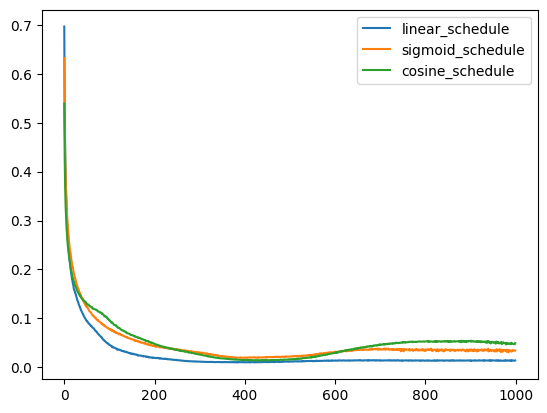

In [180]:
sns.lineplot(x=np.arange(1000), y=np.array(loss_arr), label='linear_schedule')
sns.lineplot(x=np.arange(1000), y=np.array(loss_arr_sigm), label='sigmoid_schedule')
sns.lineplot(x=np.arange(1000), y=np.array(loss_arr_cos), label='cosine_schedule')

In [28]:
classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [29]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 10

In [125]:
imgs = batch_noisy[:10] - 1e-4 #+ torch.randn_like(batch_noisy[:10]) * 1e-3 #torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
for i in reversed(range(diffusion_model.timesteps)):
    t = torch.full((1,), i, dtype=torch.long, device=device)
    labels = torch.tensor([8] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
    imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [121]:
imgs = batch_noisy[:10] - 1e-4 #+ torch.randn_like(batch_noisy[:10]) * 1e-3 #torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
for i in reversed(range(diffusion_model.timesteps)):
    t = torch.full((1,), i, dtype=torch.long, device=device)
    labels = torch.tensor([8] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
    imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)

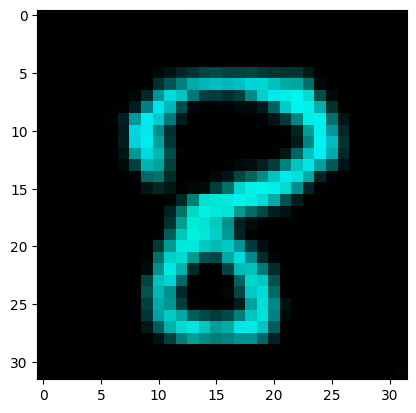

In [116]:
plt.imshow(reverse_transform(imgs)[0].cpu().permute(1, 2, 0))

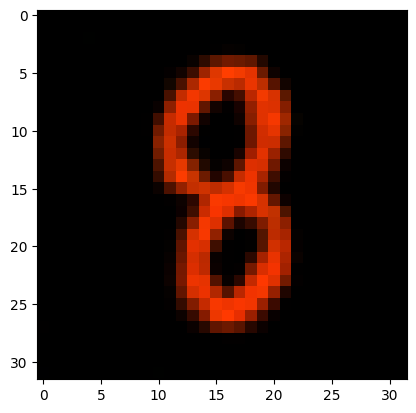

In [118]:
plt.imshow(reverse_transform(imgs)[0].cpu().permute(1, 2, 0))

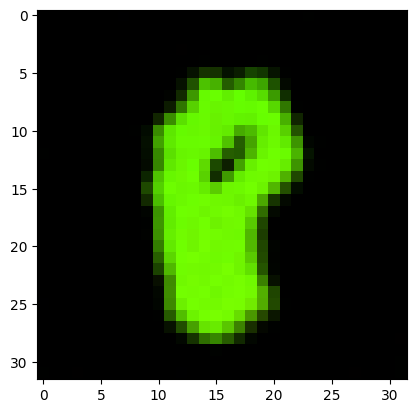

In [120]:
plt.imshow(reverse_transform(imgs)[0].cpu().permute(1, 2, 0))

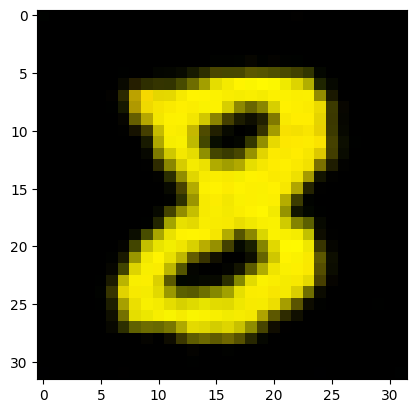

In [122]:
plt.imshow(reverse_transform(imgs)[0].cpu().permute(1, 2, 0))

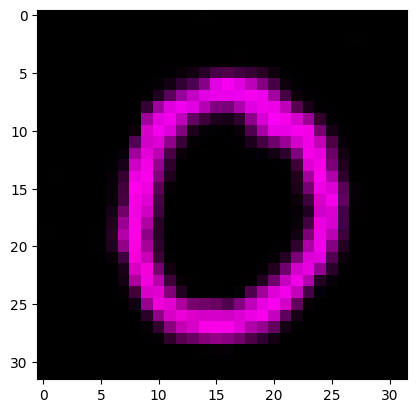

In [110]:
plt.imshow(reverse_transform(imgs)[5].cpu().permute(1, 2, 0))

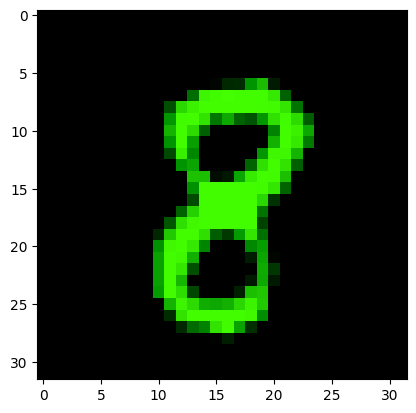

In [111]:
plt.imshow(data[0][0].permute(1, 2, 0))

In [85]:
reverse_transform(imgs)[7].detach().cpu().float().mean()

tensor(23.1090)

In [144]:
data = next(iter(trainloader))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [145]:
batch_noisy, noise = diffusion_model.forward(data[0].to(device), torch.ones(128).long().to(device) * 999, device)

In [156]:
from scipy.stats import shapiro

batch_noisy, noise = diffusion_model.forward(data[0].to(device), torch.ones(128).long().to(device) * 999, device)
linear_pvals = []
for i in batch_noisy:
  for sq in i:
    for ssq in sq:
      linear_pvals.append(shapiro(ssq.cpu()).pvalue)

batch_noisy, noise = dm_cosine.forward(data[0].to(device), torch.ones(128).long().to(device) * 999, device)
cosine_pvals = []
for i in batch_noisy:
  for sq in i:
    for ssq in sq:
      cosine_pvals.append(shapiro(ssq.cpu()).pvalue)


batch_noisy, noise = dm_sigmoid.forward(data[0].to(device), torch.ones(128).long().to(device) * 999, device)
sigmoid_pvals = []
for i in batch_noisy:
  for sq in i:
    for ssq in sq:
      sigmoid_pvals.append(shapiro(ssq.cpu()).pvalue)



In [152]:
len(linear_pvals)

12288

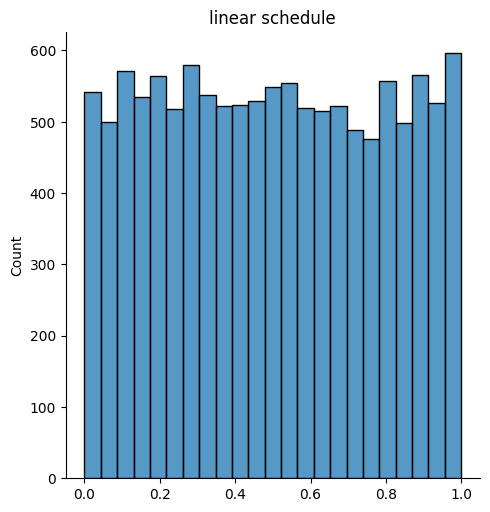

In [162]:
ax = sns.displot(linear_pvals).set(title='linear schedule')

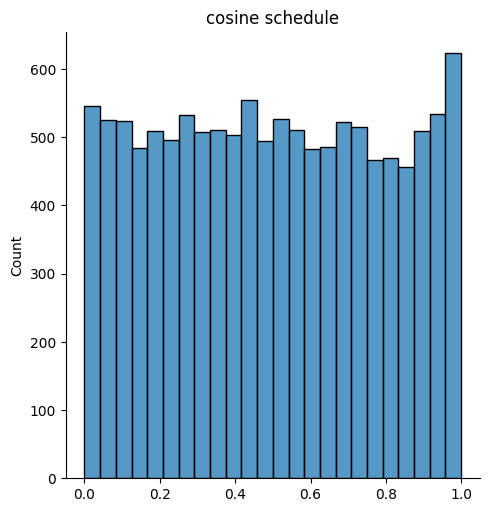

In [163]:
ax = sns.displot(cosine_pvals).set(title='cosine schedule')

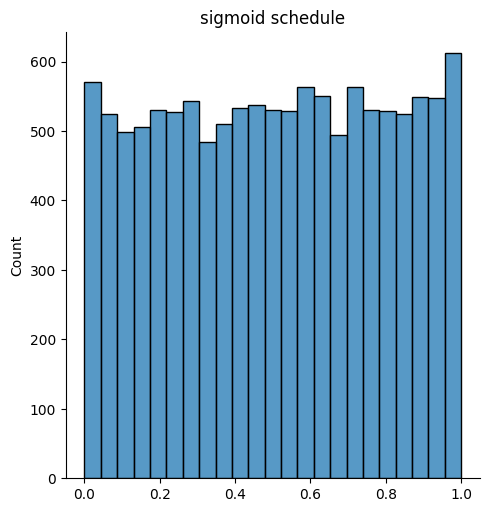

In [164]:
ax = sns.displot(sigmoid_pvals).set(title='sigmoid schedule')

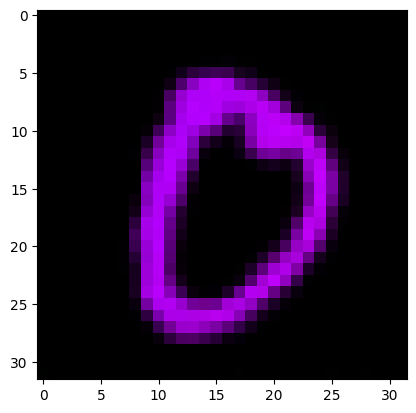

In [70]:
plt.imshow(reverse_transform(imgs)[7].detach().cpu().permute(1, 2, 0))

In [127]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device))
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img).detach().cpu().permute(1, 2, 0))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<Figure size 1500x1500 with 0 Axes>

In [49]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img).detach().cpu().permute(1, 2, 0))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()

<Figure size 1500x1500 with 0 Axes>